In [1]:
from lib.video_dataset import VideoFrameDataset
from config.dataset import get_dataset_path


d:\Proyectos\TFG\Sign2Text\Project\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys

sys.path.append("../")

from common.config.torch_config import get_transform, unnormalize, device
from common.utils.output import plot_tensor, plot_train_val_data


## HYPERPARAMETERS

In [3]:
from config.const import *

In [4]:
data_path, model_path = get_dataset_path(
    dataset="WLASL/videos", model_name="WLASL_testing"
)
multiple_transform = get_transform(IMAGE_SIZE)


In [5]:
dataset = VideoFrameDataset(
    root_path=data_path,
    transform=multiple_transform,
    image_size=IMAGE_SIZE,
    num_segments=NUM_SEGMENTS,
    frames_per_segment=FRAMES_PER_SEGMENT,
)

classes = dataset.classes
print(classes)

['all', 'before', 'book', 'drink', 'help', 'no', 'walk', 'yes']


In [6]:
from utils.loader import split_dataset

In [7]:
train_loader, test_loader, validation_loader = split_dataset(
    dataset, train_split=0.70, validation_split=0.1, batch_size=BATCH_SIZE
)

In [8]:
print(len(train_loader), len(validation_loader), len(test_loader))

55 8 16


### Tensorboard logger and writter

In [9]:
from torch.utils.tensorboard.writer import SummaryWriter

In [10]:
writer = SummaryWriter("./tensorboard/logs")

### Example of input of net

> Initial input = [BATCH_SIZE, NUMBER_OF_FRAMES, CHANNELS, HEIGHT, WIDTH]

This example shows first example (first video) in first batch

In [11]:
from torchvision.utils import make_grid
from torch import nn

In [12]:
def plot_grid(
    tensor,
    dims=(1, 2, 0),
    nrow=FRAMES_PER_SEGMENT * NUM_SEGMENTS,
    unnorm=True,
    start_dim=0,
    end_dim=1,
):
    flat = nn.Flatten(start_dim=start_dim, end_dim=end_dim)  # Flatten batch to plot.

    flatted_tensor = flat(tensor)
    grid = make_grid(flatted_tensor.cpu(), nrow=nrow)

    if unnorm:
        grid = unnormalize(grid)

    plot_tensor(grid, dims)
    return grid

### Show input of the net (entire batch)

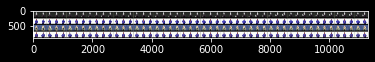

torch.Size([4, 50, 3, 224, 224])
torch.Size([4])
torch.Size([4, 50, 42, 2])


In [13]:
first_batch, (ground_classes, ground_poses) = next(iter(train_loader))
grid = plot_grid(first_batch)

print(first_batch.shape)
print(ground_classes.shape)
print(ground_poses.shape)

#### Save grid to tensorboard

In [14]:
writer.add_image(f"Example of full batch with {BATCH_SIZE} videos", grid)

#### Show specific frame of specific video

In [15]:
n_video = 0
frame_of_video = 5

### Show one video alone

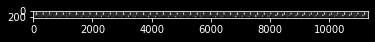

In [16]:
video = first_batch[n_video]
_ = plot_grid(video, nrow=len(video), end_dim=0)

### Show one image

In [17]:
img = video[frame_of_video]

In [18]:
target = ground_classes[n_video]

help


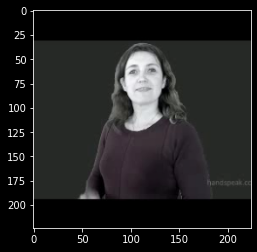

In [19]:
print(classes[target])
grid = plot_grid(img, end_dim=0)
writer.add_image("Example of image", grid)

### Show pose for gesture

In [20]:
import matplotlib.pyplot as plt

In [21]:
video_poses = ground_poses[n_video]
img_pose = video_poses[frame_of_video]
POSES_PER_FRAME = img_pose.shape[0] * img_pose.shape[1]
print(img_pose.shape)

torch.Size([42, 2])


In [22]:
norm_img_pose = img_pose * IMAGE_SIZE
img_pose_transpose = norm_img_pose.T

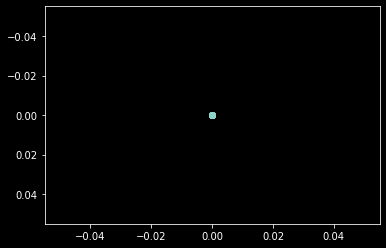

In [23]:
x, y = img_pose_transpose[0], img_pose_transpose[1]

plt.scatter(x, y)
plt.gca().invert_yaxis()

### Show pose and image one on top of the other

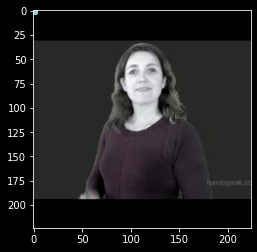

In [24]:
unorm_img = unnormalize(img)

plt.scatter(x, y)
plt.imshow(unorm_img.permute(1, 2, 0))

fig = plt.gcf()
writer.add_figure("Example of image with pose", fig)

# fig.show()
fig

### The net will then make first and second convolution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 16, 2, 112, 112])
torch.Size([4, 32, 1, 56, 56])


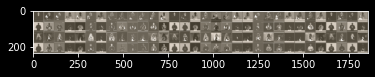

In [25]:
hidden_1, hidden_2 = 16, 32

conv1 = nn.Conv3d(
    FRAMES_PER_SEGMENT * NUM_SEGMENTS,
    hidden_1,
    kernel_size=(2, 3, 3),
    stride=2,
    padding=1,
)
conv2 = nn.Conv3d(hidden_1, hidden_2, kernel_size=3, stride=2, padding=1)
relu = nn.LeakyReLU()
batch_1 = nn.BatchNorm3d(hidden_1)
batch_2 = nn.BatchNorm3d(hidden_2)

x = first_batch

x = conv1(x)
x = relu(x)
x = batch_1(x)

print(x.shape)

x = conv2(x)
x = relu(x)
x = batch_2(x)

print(x.shape)


_ = plot_grid(x, nrow=hidden_2)

## Check balance status of the loaders

In [26]:
# from nets.common.utils.balance import check_balance_status

# print(check_balance_status(test_loader, classes))
# print(check_balance_status(validation_loader, classes))
# print(check_balance_status(train_loader, classes))

In [27]:
from lib.model import CNN

num_frames = FRAMES_PER_SEGMENT * NUM_SEGMENTS
model = CNN(
    num_classes=len(classes),
    num_frames=num_frames,
    image_size=IMAGE_SIZE,
    num_pose_points=POSES_PER_FRAME * num_frames,
)

# print(model)

In [28]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Sequential: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv3d: 3-1                  57,664
│    │    └─MaxPool3d: 3-2               --
│    │    └─BatchNorm3d: 3-3             128
│    └─Sequential: 2-2                   --
│    │    └─Conv3d: 3-4                  221,312
│    │    └─MaxPool3d: 3-5               --
│    │    └─BatchNorm3d: 3-6             256
├─Sequential: 1-2                        --
│    └─Dropout: 2-3                      --
├─Sequential: 1-3                        --
│    └─Sequential: 2-4                   --
│    │    └─Linear: 3-7                  314,716,416
│    │    └─LeakyReLU: 3-8               --
│    └─Sequential: 2-5                   --
│    │    └─Linear: 3-9                  100,360
│    │    └─LeakyReLU: 3-10              --
│    └─Softmax: 2-6                      --
├─Sequential: 1-4                        --
│ 

In [29]:
writer.add_graph(model, first_batch)
writer.close()

### Grafo del modelo con tensorboard

<img src="https://i.imgur.com/cvkNqyB.png" alt="Grafo modelo con tensorboard" width="400"/>

In [30]:
from lib.train import train_model

In [31]:
train_costs, val_costs, train_accs, val_accs = train_model(
    model,
    train_loader,
    validation_loader,
    device,
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
    writer=writer,
)

Training on device: cuda
Epoch: 1/2 | Train Loss: 2.0656 | Val Loss: 2.0141 | Train Acc: 31.7972% | Val Acc: 35.4839% |  LR: 0.01
Epoch: 2/2 | Train Loss: 1.9395 | Val Loss: 1.9093 | Train Acc: 42.8571% | Val Acc: 48.3871% |  LR: 0.01


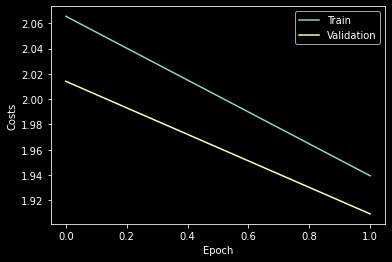

<Figure size 72x72 with 0 Axes>

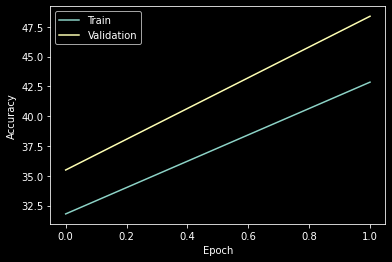

<Figure size 72x72 with 0 Axes>

In [32]:
plot_train_val_data(train_costs, val_costs, ylabel="Costs")
plot_train_val_data(train_accs, val_accs, ylabel="Accuracy")

In [33]:
import sys

sys.path.append("../")

from common.utils.check_accuracy import check_accuracy

## Probamos el acc con el dataset de prueba reservado

In [34]:
check_accuracy(train_loader, model, classes, device, n_batchs=10, has_pose=True)

Predictions for batch 1 
['drink', 'book', 'book', 'before']
Ground truth for batch 1
['walk', 'book', 'book', 'before']
---------------------------------


Predictions for batch 2 
['before', 'drink', 'before', 'before']
Ground truth for batch 2
['before', 'drink', 'before', 'help']
---------------------------------


Predictions for batch 3 
['book', 'book', 'drink', 'before']
Ground truth for batch 3
['book', 'book', 'drink', 'yes']
---------------------------------


Predictions for batch 4 
['before', 'book', 'before', 'book']
Ground truth for batch 4
['yes', 'book', 'before', 'no']
---------------------------------


Predictions for batch 5 
['drink', 'before', 'drink', 'before']
Ground truth for batch 5
['all', 'drink', 'book', 'drink']
---------------------------------


Predictions for batch 6 
['book', 'drink', 'drink', 'drink']
Ground truth for batch 6
['book', 'walk', 'drink', 'before']
---------------------------------


Predictions for batch 7 
['drink', 'drink', 'drink',

In [35]:
check_accuracy(validation_loader, model, classes, device, has_pose=True)

Predictions for batch 1 
['drink', 'before', 'book', 'book']
Ground truth for batch 1
['no', 'help', 'book', 'book']
---------------------------------


Predictions for batch 2 
['book', 'drink', 'book', 'book']
Ground truth for batch 2
['book', 'help', 'before', 'book']
---------------------------------


Predictions for batch 3 
['drink', 'drink', 'drink', 'book']
Ground truth for batch 3
['drink', 'walk', 'drink', 'book']
---------------------------------


Predictions for batch 4 
['before', 'before', 'drink', 'book']
Ground truth for batch 4
['all', 'drink', 'drink', 'book']
---------------------------------


Predictions for batch 5 
['drink', 'drink', 'drink', 'book']
Ground truth for batch 5
['drink', 'no', 'drink', 'yes']
---------------------------------


Predictions for batch 6 
['drink', 'drink', 'drink', 'book']
Ground truth for batch 6
['yes', 'walk', 'drink', 'book']
---------------------------------


Predictions for batch 7 
['book', 'drink', 'book', 'before']
Ground 

In [36]:
check_accuracy(test_loader, model, classes, device, has_pose=True)


Predictions for batch 1 
['drink', 'drink', 'before', 'drink']
Ground truth for batch 1
['yes', 'drink', 'book', 'drink']
---------------------------------


Predictions for batch 2 
['drink', 'book', 'before', 'before']
Ground truth for batch 2
['drink', 'book', 'walk', 'help']
---------------------------------


Predictions for batch 3 
['drink', 'before', 'book', 'book']
Ground truth for batch 3
['all', 'all', 'yes', 'before']
---------------------------------


Predictions for batch 4 
['before', 'before', 'drink', 'drink']
Ground truth for batch 4
['no', 'drink', 'help', 'drink']
---------------------------------


Predictions for batch 5 
['before', 'before', 'drink', 'before']
Ground truth for batch 5
['all', 'walk', 'yes', 'walk']
---------------------------------


Predictions for batch 6 
['before', 'book', 'book', 'before']
Ground truth for batch 6
['walk', 'all', 'book', 'before']
---------------------------------


Predictions for batch 7 
['drink', 'book', 'drink', 'book'

## Exportamos modelo

In [37]:
from torch import save, onnx, randn

In [38]:
save(model, model_path)
print(f"Model exported to {model_path}")

Model exported to d:\Proyectos\TFG\Sign2Text\Project\models\WLASL_testing.pth


## Exportamos modelo en formato ONNX para poder usar en otras plataformas

In [39]:
dummy_input = randn(
    BATCH_SIZE,
    FRAMES_PER_SEGMENT * NUM_SEGMENTS,
    3,
    IMAGE_SIZE,
    IMAGE_SIZE,
    device=device,
)

onnx.export(
    model,
    dummy_input,
    model_path.replace(".pth", ".onnx"),
    input_names=["input"],
    dynamic_axes={"input": {0: "batch_size"}},
)

### Mostramos el grafo de onnx con [_netrón_](https://netron.app/)

<img src="https://i.imgur.com/jDkeBMz.png" alt="Grafo del modelo exportado con netrón" width="400"/>
